In [6]:
import pandas as pd #Biblioteca responsavel pela manipulação dos dados
import numpy as np #Biblioteca pra trabalhar com Array e Matriz
import seaborn as sns #Biblioteca de Plot
import matplotlib.pyplot as plt #Tambem uma biblioteca de plot(Trabalha em conjunto com seaborn)

#Vamos vendo com o tempo o que sera usado e descartado, como exemplo vamos deixar esses 3 como principais pra teste de acuracia.
from sklearn.ensemble import RandomForestClassifier #Modelo de Machine Learning - TESTE 1
from sklearn.linear_model import LinearRegression, LogisticRegression #Modelo de Machine Learning - TESTE 2
from sklearn.naive_bayes import MultinomialNB #use to predict

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score #Anda em conjunto com o ML, 3 tipos de métricas para aprendizagem da maquina e testes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

#modelo de seleção
from sklearn.model_selection import train_test_split #Modelo de Machine Learning - TESTE 3

from nltk.tokenize import RegexpTokenizer #split words frin text
from nltk.stem.snowball import SnowballStemmer #stemmes words
from sklearn.feature_extraction.text import CountVectorizer #create sparse matrix of words usind regexp

from sklearn.tree import export_graphviz
import graphviz

from collections import Counter

In [7]:
df = pd.read_csv('malicious_phish.csv') #Coletando o primeiro dataset

In [8]:
df.fillna(df.mode().iloc[0], inplace=True) #substituir os campos nulos por zero
print(df.info()) #conteudo do dataset 1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB
None


In [9]:
df.head(10)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


In [10]:
df.isnull().sum() #mostra os valores nulos no dataset 1

url     0
type    0
dtype: int64

In [11]:
df.describe() #Conteudo do dataset 1: 641.191 dados e 4 tipos de classificação

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


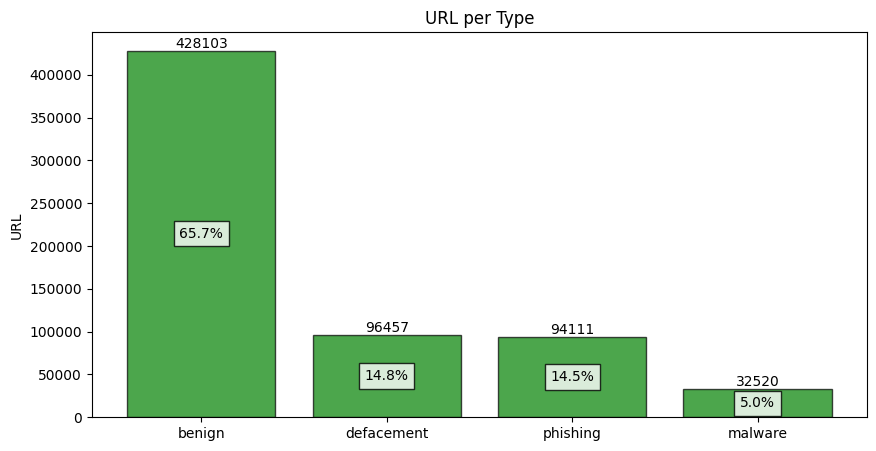

Colunas do dataframe DF Index(['url', 'type'], dtype='object'), 
Valores para ML: type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64, 
Conteúdo: RangeIndex(start=0, stop=651191, step=1)



In [12]:
types = df['type'].values

counter_types = Counter(types)

type_names = list(counter_types.keys())
type_values = list(counter_types.values())

sorted_indices = np.argsort(type_values)[::-1]
type_names = [type_names[i] for i in sorted_indices]
type_values = [type_values[i] for i in sorted_indices]

total_count = sum(type_values)
percentages = [value / total_count * 100 for value in type_values]

pattern = ''

y_pos = np.arange(len(type_names))
plt.figure(1, figsize=(10, 5))
bars = plt.bar(y_pos, type_values, align='center', alpha=0.7, color='green', edgecolor='black', hatch=pattern)

for bar, value, percentage in zip(bars, type_values, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{value}', ha='center', va='bottom')
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{percentage:.1f}%', ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

plt.xticks(y_pos, type_names)
plt.ylabel('URL')
plt.title('Type')
plt.show()

print(f"Colunas do dataframe DF {df.columns}, \nValores para ML: {df['type'].value_counts()}, \nConteúdo: {df.index}\n" )

In [13]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')  #O Tokenizer "corta" uma string usando expressões regulares, cada match que corresponde aos tokens ou aos separadores entre os tokens.

In [14]:
print(df.url[2])

tokenizer.tokenize(df.url[2])

bopsecrets.org/rexroth/cr/1.htm


['bopsecrets', 'org', 'rexroth', 'cr', 'htm']

In [15]:
df['text_tokenized'] = df.url.map(lambda t: tokenizer.tokenize(t))

In [16]:
df.sample(5)

,url,type,text_tokenized
30995,http://roval.com/prob8a.htm,defacement,"[http, roval, com, prob, a, htm]"
6277,eddiefoy.com/FoyFamily.html,benign,"[eddiefoy, com, FoyFamily, html]"
249644,denverfilm.org/filmcenter/detail.aspx?id=23850,benign,"[denverfilm, org, filmcenter, detail, aspx, id]"
201231,http://www.ekino-neureut.de/index.php?option=c...,defacement,"[http, www, ekino, neureut, de, index, php, op..."
305119,http://www.feuer-wehr.de/index.php?option=com_...,defacement,"[http, www, feuer, wehr, de, index, php, optio..."


In [17]:
stemmer = SnowballStemmer("english")

In [18]:
df['text_stemmed'] = df['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])

In [19]:
df.sample(10)

,url,type,text_tokenized,text_stemmed
99783,worldsbestfilms.blogspot.com/2009/08/top-ranke...,benign,"[worldsbestfilms, blogspot, com, top, ranked, ...","[worldsbestfilm, blogspot, com, top, rank, rom..."
180835,offsales.blogspot.com/,benign,"[offsales, blogspot, com]","[offsal, blogspot, com]"
442648,http://appelboerderij.nl/fruitplantage,defacement,"[http, appelboerderij, nl, fruitplantage]","[http, appelboerderij, nl, fruitplantag]"
433078,song-list.net/pebbles/songs,benign,"[song, list, net, pebbles, songs]","[song, list, net, pebbl, song]"
441690,bank-security-text-message.wfb-sms.xyz,phishing,"[bank, security, text, message, wfb, sms, xyz]","[bank, secur, text, messag, wfb, sms, xyz]"
249851,http://www.craigauricht.com.au/index.php?optio...,defacement,"[http, www, craigauricht, com, au, index, php,...","[http, www, craigauricht, com, au, index, php,..."
22533,http://hawkhills.com/index.html,defacement,"[http, hawkhills, com, index, html]","[http, hawkhil, com, index, html]"
8815,corporationwiki.com/people/index.aspx/W/15/6/,benign,"[corporationwiki, com, people, index, aspx, W]","[corporationwiki, com, peopl, index, aspx, w]"
537129,http://5.182.211.184/armv6l,malware,"[http, armv, l]","[http, armv, l]"
585277,paypal.com.cgi.bin.marketingweb.cmd.login.run....,benign,"[paypal, com, cgi, bin, marketingweb, cmd, log...","[paypal, com, cgi, bin, marketingweb, cmd, log..."


In [20]:
df['text_sent'] = df['text_stemmed'].map(lambda l: ' '.join(l))

In [21]:
df.sample(5)

,url,type,text_tokenized,text_stemmed,text_sent
219970,https://paytm.com/blog/forbes-india-profiled-i...,benign,"[https, paytm, com, blog, forbes, india, profi...","[https, paytm, com, blog, forb, india, profil,...",https paytm com blog forb india profil india n...
80372,makinggameofthrones.com/,benign,"[makinggameofthrones, com]","[makinggameofthron, com]",makinggameofthron com
408708,localhistories.org/germany.html,benign,"[localhistories, org, germany, html]","[localhistori, org, germani, html]",localhistori org germani html
263672,usidentify.com/l/charbonneau,benign,"[usidentify, com, l, charbonneau]","[usidentifi, com, l, charbonneau]",usidentifi com l charbonneau
417846,trails.com/tcatalog_trail.aspx?trailid=HGA004-013,benign,"[trails, com, tcatalog, trail, aspx, trailid, ...","[trail, com, tcatalog, trail, aspx, trailid, hga]",trail com tcatalog trail aspx trailid hga


In [22]:
CountVectorize = CountVectorizer()

In [19]:
feat = CountVectorize.fit_transform(df.text_sent) #transforma todo o texto que foi stemado e tokenizado

In [20]:
feat[:5].toarray() #convertendo uma matriz sparse para um array para imprimir a variavel feat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
trainX, testX, trainY, testY = train_test_split(feat, df.type)

In [22]:
#LOGISTIC REGRESSION
lr = LogisticRegression()

lr.fit(trainX,trainY)

c:\Program Files\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [23]:
lr.score(testX,testY)

0.9511111930121992

[Text(0, 0.5, 'benign'),
 Text(0, 1.5, 'defacement'),
 Text(0, 2.5, 'malware'),
 Text(0, 3.5, 'phishing')]

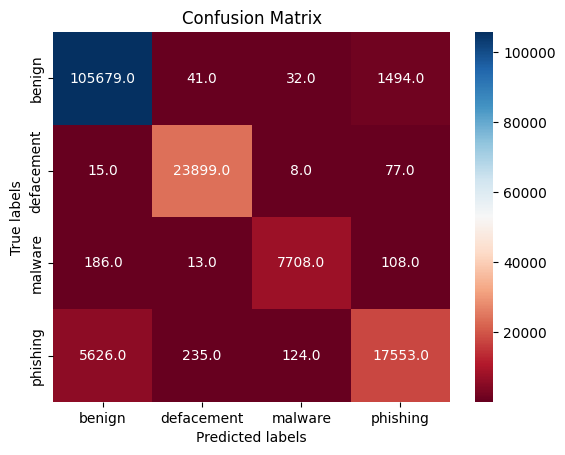

In [24]:
y_pred = lr.predict(testX)
cols = list(lr.classes_)
ax = plt.subplot()
CM_LR = confusion_matrix(testY,y_pred) 
#sns.heatmap(CM_LR, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(CM_LR, annot=True, fmt = ".1f",cmap="RdBu")
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(cols)
ax.yaxis.set_ticklabels(cols)

In [25]:
from sklearn.preprocessing import OneHotEncoder

# Supondo que 'trainY' seja um DataFrame ou Series
one_hot_encoder = OneHotEncoder()
trainY_encoded = one_hot_encoder.fit_transform(trainY.values.reshape(-1,1)).toarray()

In [26]:
reg = LinearRegression()

reg.fit(trainX, trainY_encoded)


LinearRegression()

In [27]:
reg.score(trainX, trainY_encoded)



0.9540796192673685

In [28]:
y_pred2 = reg.predict(trainX)
cols2 = list(reg.classes_)
ax2 = plt.subplot()
CM_LR2 = confusion_matrix(trainY_encoded,y_pred2) 
#sns.heatmap(CM_LR, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(CM_LR, annot=True, fmt = ".1f",cmap="RdBu")
# labels, title and ticks
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_title('Confusion Matrix')
ax2.xaxis.set_ticklabels(cols)
ax2.yaxis.set_ticklabels(cols)

AttributeError: 'LinearRegression' object has no attribute 'classes_'